In [1]:
from pathlib import Path
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import trange

from kgi import apply_kgi_to_model

In [2]:
# attempt to enable LaTeX rendering
# change to `False` if you get an error during plotting (latex not installed)
plt.rcParams['text.usetex'] = True

# Data

In [3]:
def batchify(data, labels, batch_size):
    """ manually batchify data """
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size], labels[i:i + batch_size]


def load_dataset_to_gpu(batch_size=512, device="cuda"):
    """ load dataset in CPU, process, and move to GPU """
    transform = transforms.Compose([transforms.ToTensor(), ])
    train_dataset = torchvision.datasets.CIFAR10(root='./datasets_torch',
                                                 train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./datasets_torch',
                                                train=False, download=True, transform=transform)
    train_data = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))]).to(device)
    train_labels = torch.tensor(
        [train_dataset[i][1] for i in range(len(train_dataset))], dtype=torch.long).to(device)
    test_data = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))]).to(device)
    test_labels = torch.tensor(
        [test_dataset[i][1] for i in range(len(test_dataset))], dtype=torch.long).to(device)
    train_batches = list(batchify(train_data, train_labels, batch_size))
    test_batches = list(batchify(test_data, test_labels, batch_size))
    return train_batches, test_batches


device_ = "cuda" if torch.cuda.is_available() else "cpu"
train_set, test_set = load_dataset_to_gpu(device=device_)

Files already downloaded and verified
Files already downloaded and verified


# Training

In [4]:
class MLP(nn.Module):
    def __init__(self, batch_norm):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc_out = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.batch_norm1 = nn.BatchNorm1d(256) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm1d(128) if batch_norm else nn.Identity()
        self.batch_norm3 = nn.BatchNorm1d(128) if batch_norm else nn.Identity()

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc_out(x)
        return x

In [5]:
def train(kgi, batch_norm, seed=0, num_epochs=10000, save_every=10, progress_bar=True):
    torch.manual_seed(seed)

    # model
    model = MLP(batch_norm)
    if kgi:
        apply_kgi_to_model(model, knot_low=0, knot_high=1,
                           perturb_factor=0.2, kgi_by_bias=False,
                           homogenous_factor=-1)
    model = model.to(device_)
    model.train()

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # train loop
    loss_history = []
    loop = trange(num_epochs, desc="Training Epochs", disable=not progress_bar)
    for epoch in loop:
        running_loss = 0.0
        for images, labels in train_set:
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch + 1) % save_every == 0:
            epoch_loss = running_loss / len(train_set)
            loss_history.append(epoch_loss)
            loop.set_postfix({"Epoch Loss": f"{epoch_loss:.2e}"})

    # evaluation
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_set:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # noqa

    accuracy = 100 * correct / total
    if progress_bar:
        print(f'Final Accuracy on test set: {accuracy:.2f}%')
    return loss_history, accuracy

In [6]:
# train all models
seeds = list(range(10))  # use `seeds = [0]` for fast test
epochs = 20000  # use a smaller one for fast test
out_dir = Path("results/cifar10_paper")

out_dir.mkdir(exist_ok=True, parents=True)
for seed_ in seeds:
    for kgi_ in [False, True]:
        for batch_norm_ in [False, True]:
            name_ = f"{seed_}_{kgi_}_{batch_norm_}"
            if not (out_dir / name_).exists():
                t0 = time()
                hist_, acc = train(kgi_, batch_norm_, seed_, epochs, progress_bar=True)
                np.savetxt(out_dir / name_, hist_, header=f"{acc}")
                print(f"{name_} trained in {(time() - t0) / 60:.1f} min, "
                      f"loss={hist_[-1]:.2e}, acc={acc:.2f}%")
            else:
                print(f"{name_} exists")

0_False_False exists
0_False_True exists
0_True_False exists
0_True_True exists
1_False_False exists
1_False_True exists
1_True_False exists
1_True_True exists
2_False_False exists
2_False_True exists
2_True_False exists
2_True_True exists
3_False_False exists
3_False_True exists
3_True_False exists
3_True_True exists
4_False_False exists
4_False_True exists
4_True_False exists
4_True_True exists
5_False_False exists
5_False_True exists
5_True_False exists
5_True_True exists
6_False_False exists
6_False_True exists
6_True_False exists
6_True_True exists
7_False_False exists
7_False_True exists
7_True_False exists
7_True_True exists
8_False_False exists
8_False_True exists
8_True_False exists
8_True_True exists
9_False_False exists
9_False_True exists
9_True_False exists
9_True_True exists


# Analysis

### Metrics

In [7]:
def print_metrics(kgi, batch_norm):
    losses = []
    slowness = []
    accs = []
    for seed in seeds:
        # read history
        name = f"{seed}_{kgi}_{batch_norm}"
        hist = np.loadtxt(out_dir / name)
        # use average of last 50 epochs (5 * 10) as final loss
        final_loss = hist[-10:].mean()
        losses.append(final_loss)
        # AUC for convergence slowness
        init_loss = hist[:10].mean()
        slowness.append(hist.mean() / init_loss)
        # read relative error
        with open(out_dir / name) as fs:
            acc_str = fs.readline()
        accs.append(float(acc_str[1:]))
    losses = np.array(losses) * 10
    slowness = np.array(slowness) * 10
    accs = np.array(accs)
    print("\nKGI" if kgi else "\nNo KGI")
    print(f"Loss: {losses.mean():.2f} ± {losses.std():.2f}")
    print(f"slowness: {slowness.mean():.2f} ± {slowness.std():.2f}")
    print(f"Accuracy: {accs.mean():.2f} ± {accs.std():.2f}%")
    return losses.mean(), losses.std(), slowness.mean(), slowness.std(), accs.mean(), accs.std()


# without batch norm
lmf, lsf, smf, ssf, amf, asf = print_metrics(False, False)
lmt, lst, smt, sst, amt, ast = print_metrics(True, False)
print("\nCopy to table")
print(f"CIFAR-10 & "
      f"${lmf:.2f}\!\pm\!{lsf:.2f}$ & ${lmt:.2f}\!\pm\!{lst:.2f}$ & "
      f"${smf:.2f}\!\pm\!{ssf:.2f}$ & ${smt:.2f}\!\pm\!{sst:.2f}$ & Accuracy & "
      f"${amf:.2f}\!\pm\!{asf:.2f}\%$ & ${amt:.2f}\!\pm\!{ast:.2f}\%$")

# with batch norm
print("\n==========================\n")
lmf, lsf, smf, ssf, amf, asf = print_metrics(False, True)
lmt, lst, smt, sst, amt, ast = print_metrics(True, True)
print("\nCopy to table")
print(f"CIFAR-10 & "
      f"${lmf:.2f}\!\pm\!{lsf:.2f}$ & ${lmt:.2f}\!\pm\!{lst:.2f}$ & "
      f"${smf:.2f}\!\pm\!{ssf:.2f}$ & ${smt:.2f}\!\pm\!{sst:.2f}$ & Accuracy & "
      f"${amf:.2f}\!\pm\!{asf:.2f}\%$ & ${amt:.2f}\!\pm\!{ast:.2f}\%$")


No KGI
Loss: 1.88 ± 0.24
slowness: 2.60 ± 0.21
Accuracy: 47.42 ± 0.25%

KGI
Loss: 1.58 ± 0.16
slowness: 2.29 ± 0.16
Accuracy: 47.71 ± 0.37%

Copy to table
CIFAR-10 & $1.88\!\pm\!0.24$ & $1.58\!\pm\!0.16$ & $2.60\!\pm\!0.21$ & $2.29\!\pm\!0.16$ & Accuracy & $47.42\!\pm\!0.25\%$ & $47.71\!\pm\!0.37\%$



No KGI
Loss: 0.06 ± 0.00
slowness: 0.37 ± 0.00
Accuracy: 51.10 ± 0.42%

KGI
Loss: 0.06 ± 0.00
slowness: 0.38 ± 0.00
Accuracy: 51.21 ± 0.37%

Copy to table
CIFAR-10 & $0.06\!\pm\!0.00$ & $0.06\!\pm\!0.00$ & $0.37\!\pm\!0.00$ & $0.38\!\pm\!0.00$ & Accuracy & $51.10\!\pm\!0.42\%$ & $51.21\!\pm\!0.37\%$


### Loss history

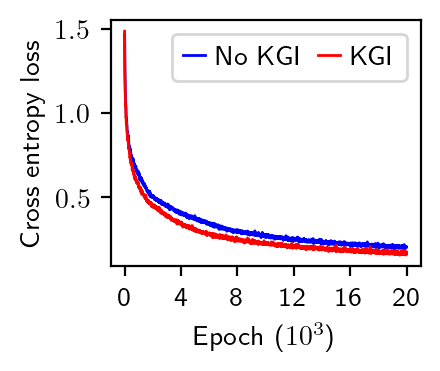

In [8]:
def moving_ave(series, window_size):
    """ Moving average to smooth the loss history a little bit """
    return np.convolve(series, np.ones(window_size) / window_size, mode='valid')


_, ax = plt.subplots(figsize=(5 / 2.5, 4 / 2.5), dpi=200)
seed_ = 0
hist_def = np.loadtxt(out_dir / f"{seed_}_{False}_{False}")
hist_kgi = np.loadtxt(out_dir / f"{seed_}_{True}_{False}")
ax.plot(np.arange(1, epochs + 1, 10), moving_ave(hist_def, 1), label="No KGI", lw=1, c='b')
ax.plot(np.arange(1, epochs + 1, 10), moving_ave(hist_kgi, 1), label="KGI", lw=1, c='r')
ax.set_xticks([0, 4000, 8000, 12000, 16000, 20000],
              [0, 4, 8, 12, 16, 20])
ax.set_ylabel("Cross entropy loss")
ax.set_xlabel("Epoch ($10^3$)")
ax.legend(ncol=2, handlelength=.8, columnspacing=.5, handletextpad=.4)
plt.show()